<a href="https://colab.research.google.com/github/dprugby/custom_CNN/blob/master/custom_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Custom ResNets with Keras

In [11]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt

## A traditional CNN (as a benchmark on Fashion CIFAR10)

In [2]:
# import CIFAR10
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_valid, X_train = X_train_full[:10000] / 255., X_train_full[10000:] / 255.
y_valid, y_train = y_train_full[:10000], y_train_full[10000:]
X_test = X_test / 255.

print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)
(40000, 1) (10000, 1) (10000, 1)


In [3]:
# assemble a simple CNN
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation="relu", padding="same", input_shape=[32, 32, 3]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax"),
])

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)         5

In [5]:
# compile and train the model
optimizer = tf.keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), batch_size=128)

Epoch 1/50
313/313 [==============================] - 17s 54ms/step - loss: 2.3105 - accuracy: 0.1110 - val_loss: 2.2242 - val_accuracy: 0.1355
Epoch 2/50
313/313 [==============================] - 16s 52ms/step - loss: 2.1280 - accuracy: 0.1925 - val_loss: 1.8094 - val_accuracy: 0.3226
Epoch 3/50
313/313 [==============================] - 16s 52ms/step - loss: 1.7926 - accuracy: 0.3251 - val_loss: 1.5906 - val_accuracy: 0.4009
Epoch 4/50
313/313 [==============================] - 16s 52ms/step - loss: 1.6132 - accuracy: 0.4137 - val_loss: 1.4215 - val_accuracy: 0.4755
Epoch 5/50
313/313 [==============================] - 16s 52ms/step - loss: 1.4862 - accuracy: 0.4631 - val_loss: 1.3370 - val_accuracy: 0.5060
Epoch 6/50
313/313 [==============================] - 16s 52ms/step - loss: 1.3846 - accuracy: 0.5069 - val_loss: 1.2465 - val_accuracy: 0.5476
Epoch 7/50
313/313 [==============================] - 16s 52ms/step - loss: 1.2893 - accuracy: 0.5429 - val_loss: 1.1791 - val_accuracy:

In [6]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 2.2135 - accuracy: 0.6704


[2.21346116065979, 0.6704000234603882]

In [9]:
logs_df = pd.DataFrame(history.history)
logs_df.head()

,loss,accuracy,val_loss,val_accuracy
0,2.310544,0.11100,2.224242,0.1355
1,2.127966,0.19245,1.809364,0.3226
2,1.792600,0.32510,1.590587,0.4009
3,1.613163,0.41370,1.421469,0.4755
4,1.486246,0.46305,1.337034,0.5060


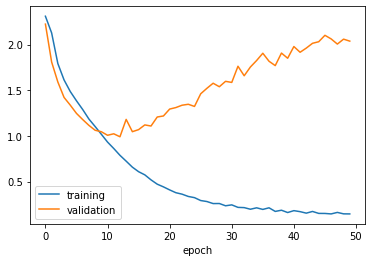

In [12]:
plt.plot(history.history["loss"], label="training")
plt.plot(history.history["val_loss"], label="validation")
plt.xlabel("epoch")
plt.legend()
plt.show()

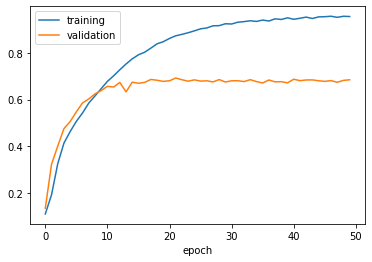

In [13]:
plt.plot(history.history["accuracy"], label="training")
plt.plot(history.history["val_accuracy"], label="validation")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [14]:
model.save('DNN.h5')
from google.colab import files
files.download("DNN.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## A shallow network with Inception blocks

In [15]:
# a custom residual unit, obtained by subclassing keras.layers.Layer
class Inception(keras.layers.Layer):
    def __init__(self, filters, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.activation = keras.activations.get(activation)
        self.layers_0 = [
        keras.layers.Conv2D(self.filters[0], 1, strides=1, padding="same", use_bias=False),
        self.activation]
        self.layers_1 = [
        keras.layers.Conv2D(self.filters[1], 1, strides=1, padding="same", use_bias=False),
        self.activation, 
        keras.layers.Conv2D(self.filters[2], 3, strides=1, padding="same", use_bias=False),
        self.activation]
        self.layers_2 = [
        keras.layers.Conv2D(self.filters[3], 1, strides=1, padding="same", use_bias=False),
        self.activation, 
        keras.layers.Conv2D(self.filters[4], 5, strides=1, padding="same", use_bias=False),
        self.activation]
        self.layers_3 = [
        keras.layers.MaxPooling2D(pool_size=2, strides=1, padding="same"), 
        keras.layers.Conv2D(self.filters[5], 5, strides=1, padding="same", use_bias=False),
        self.activation]
        
    def call(self, inputs):
        Z0 = inputs
        Z1 = inputs
        Z2 = inputs
        Z3 = inputs

        for layer in self.layers_0:
            Z0 = layer(Z0)
        for layer in self.layers_1:
            Z1 = layer(Z1)
        for layer in self.layers_2:
            Z2 = layer(Z2)
        for layer in self.layers_3:
            Z3 = layer(Z3)
        
        return tf.concat([Z0, Z1, Z2, Z3], axis=3)

In [16]:
# assemble a simple CNN
model = keras.models.Sequential([
    keras.layers.Conv2D(32, 5, activation="relu", padding="same", input_shape=[32, 32, 3]),
    keras.layers.MaxPooling2D(pool_size=3, strides=1, padding="same"),
    Inception([32, 48, 64, 8, 16, 16]),
    keras.layers.Conv2D(32, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(pool_size=3, strides=1, padding="same"),
    Inception([32, 48, 64, 8, 16, 16]),
    keras.layers.GlobalAveragePooling2D(),
    #keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax"),
])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        2432      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
inception (Inception)        (None, 32, 32, 128)       46464     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 32)        36896     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
inception_1 (Inception)      (None, 32, 32, 128)       46464     
_________________________________________________________________
global_average_pooling2d (Gl (None, 128)              

In [18]:
# compile and train the model
optimizer = tf.keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), batch_size=128)

Epoch 1/50
313/313 [==============================] - 41s 130ms/step - loss: 1.9869 - accuracy: 0.2623 - val_loss: 1.7341 - val_accuracy: 0.3650
Epoch 2/50
313/313 [==============================] - 40s 127ms/step - loss: 1.6423 - accuracy: 0.3968 - val_loss: 1.6612 - val_accuracy: 0.3958
Epoch 3/50
313/313 [==============================] - 40s 127ms/step - loss: 1.4995 - accuracy: 0.4482 - val_loss: 1.4572 - val_accuracy: 0.4655
Epoch 4/50
313/313 [==============================] - 40s 127ms/step - loss: 1.3966 - accuracy: 0.4878 - val_loss: 1.3483 - val_accuracy: 0.4965
Epoch 5/50
313/313 [==============================] - 40s 127ms/step - loss: 1.3093 - accuracy: 0.5272 - val_loss: 1.3869 - val_accuracy: 0.5076
Epoch 6/50
313/313 [==============================] - 40s 128ms/step - loss: 1.2429 - accuracy: 0.5555 - val_loss: 1.2545 - val_accuracy: 0.5518
Epoch 7/50
313/313 [==============================] - 40s 127ms/step - loss: 1.1792 - accuracy: 0.5791 - val_loss: 1.1482 - val_ac

In [19]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 4s 13ms/step - loss: 0.7689 - accuracy: 0.7469


[0.7688503861427307, 0.7469000220298767]

In [20]:
logs_df = pd.DataFrame(history.history)
logs_df.head()

,loss,accuracy,val_loss,val_accuracy
0,1.986862,0.262350,1.734110,0.3650
1,1.642319,0.396850,1.661245,0.3958
2,1.499532,0.448175,1.457193,0.4655
3,1.396600,0.487775,1.348258,0.4965
4,1.309292,0.527250,1.386950,0.5076


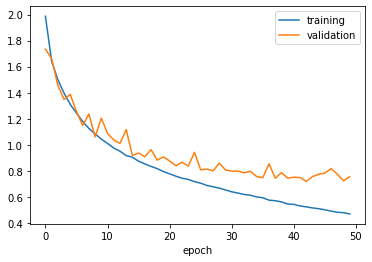

In [21]:
plt.plot(history.history["loss"], label="training")
plt.plot(history.history["val_loss"], label="validation")
plt.xlabel("epoch")
plt.legend()
plt.show()

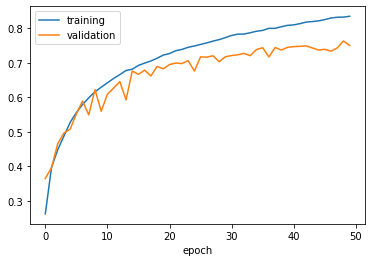

In [22]:
plt.plot(history.history["accuracy"], label="training")
plt.plot(history.history["val_accuracy"], label="validation")
plt.xlabel("epoch")
plt.legend()
plt.show()

## Mini ResNet

In [71]:
# assemble a residual block with a skip connection
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, kernel_size=3, strides=strides,
                        padding="SAME", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, kernel_size=1, strides=strides,
                        padding="SAME", use_bias=False),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [76]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, kernel_size=5, strides=1,
                        input_shape=[32, 32, 3]))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(ResidualUnit(64))
model.add(keras.layers.Dropout(0.3))
model.add(ResidualUnit(64))
model.add(keras.layers.Dropout(0.3))
model.add(ResidualUnit(128, strides=2))
model.add(keras.layers.Dropout(0.5))
model.add(ResidualUnit(128, strides=1))
model.add(keras.layers.Dropout(0.3))
model.add(ResidualUnit(256, strides=2))
model.add(keras.layers.Dropout(0.5))
model.add(ResidualUnit(256, strides=1))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(10, activation="softmax"))

In [77]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_180 (Conv2D)          (None, 28, 28, 64)        4864      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_160 (Bat (None, 14, 14, 64)        256       
_________________________________________________________________
activation_16 (Activation)   (None, 14, 14, 64)        0         
_________________________________________________________________
residual_unit_64 (ResidualUn (None, 14, 14, 64)        74240     
_________________________________________________________________
dropout_40 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
residual_unit_65 (ResidualUn (None, 14, 14, 64)      

In [78]:
# compile and train the model
optimizer = tf.keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), batch_size=128)

Epoch 1/50
313/313 [==============================] - 27s 87ms/step - loss: 1.9453 - accuracy: 0.3196 - val_loss: 2.8029 - val_accuracy: 0.1923
Epoch 2/50
313/313 [==============================] - 27s 86ms/step - loss: 1.3752 - accuracy: 0.5013 - val_loss: 1.7788 - val_accuracy: 0.4386
Epoch 3/50
313/313 [==============================] - 27s 86ms/step - loss: 1.1553 - accuracy: 0.5879 - val_loss: 1.5911 - val_accuracy: 0.4837
Epoch 4/50
313/313 [==============================] - 27s 86ms/step - loss: 1.0194 - accuracy: 0.6402 - val_loss: 1.8117 - val_accuracy: 0.4578
Epoch 5/50
313/313 [==============================] - 27s 86ms/step - loss: 0.9261 - accuracy: 0.6736 - val_loss: 1.4683 - val_accuracy: 0.5227
Epoch 6/50
313/313 [==============================] - 27s 86ms/step - loss: 0.8505 - accuracy: 0.7034 - val_loss: 1.5945 - val_accuracy: 0.5726
Epoch 7/50
313/313 [==============================] - 27s 86ms/step - loss: 0.7899 - accuracy: 0.7276 - val_loss: 1.8983 - val_accuracy:

In [79]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 3s 11ms/step - loss: 0.8315 - accuracy: 0.7977


[0.8315218687057495, 0.7976999878883362]

In [80]:
logs_df = pd.DataFrame(history.history)
logs_df.head()

,loss,accuracy,val_loss,val_accuracy
0,1.945281,0.319650,2.802887,0.1923
1,1.375227,0.501325,1.778809,0.4386
2,1.155306,0.587875,1.591099,0.4837
3,1.019446,0.640150,1.811658,0.4578
4,0.926122,0.673550,1.468285,0.5227


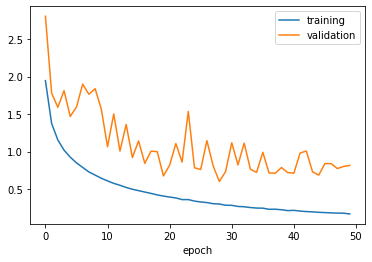

In [81]:
plt.plot(history.history["loss"], label="training")
plt.plot(history.history["val_loss"], label="validation")
plt.xlabel("epoch")
plt.legend()
plt.show()

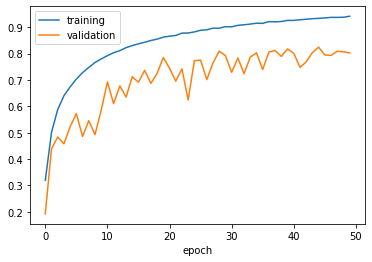

In [82]:
plt.plot(history.history["accuracy"], label="training")
plt.plot(history.history["val_accuracy"], label="validation")
plt.xlabel("epoch")
plt.legend()
plt.show()